<a href="https://colab.research.google.com/github/Kr0uxx/DA-mini-project/blob/master/%22%D0%9A%D0%B0%D0%BA_%D1%83%D0%B1%D0%B5%D0%B6%D0%B4%D0%B0%D1%82%D1%8C_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%22_%D1%88%D0%B0%D0%B1%D0%BB%D0%BE%D0%BD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

### Описание данных
***id_order*** - уникальный идентификатор.\
***test_group*** - флаг, относящий заказ к контрольной или тестовой группе.\
***time_order*** - Дата + время создания заказа.\
***time_offer*** - Дата + время первого предложения заказа водителю.\
***time_assign*** - Дата + время согласия и назначения водителя на заказ.\
***time_arrive*** - Дата + время прибытия водителя в точку "А".\
***trip_time*** - Дата + время успешного окончания поездки в точке "В".

In [15]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=186Ql_yOkTiDjn1qYo0e_feB3Frp2XtvV",sep=';')

In [16]:
df.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,2024/03/04 00:00:02,2024/03/04 00:00:43,2024/03/04 00:01:14,2024/03/04 00:09:07,2024/03/04 01:27:28
1,10002,0,2024/03/04 00:00:23,2024/03/04 00:01:00,2024/03/04 00:01:15,2024/03/04 00:08:45,2024/03/04 00:22:22
2,10003,1,2024/03/04 00:07:09,2024/03/04 00:07:45,NaN,NaN,NaN
3,10004,1,2024/03/04 00:07:12,2024/03/04 00:08:21,2024/03/04 00:08:47,2024/03/04 00:21:14,2024/03/04 01:23:25
4,10005,0,2024/03/04 00:12:00,2024/03/04 00:12:50,2024/03/04 00:13:09,2024/03/04 00:21:44,2024/03/04 00:46:45


## Как посчитать результаты эксперимента

С учетом разбивки на группы в колонке test_group, посчитать метрики, на основе которых мы потом будем принимать решения о том, есть ли различия между группами
- 1 - тестовая группа (5 км)
- 0 - контрольная группа (3 км)

**Про метрики**

Что такое метрика - это показатель, количественная или качественная характеристика, используемая для измерения и оценки эффективности чего-либо, будь то бизнес-процесс, продукт, маркетинговая кампания или любой другой аспект деятельности.

Для выводов, в рамках текущего эксперимента, мы будем использовать только **конверсии.**

[Что такое конверсии](https://skillbox.ru/media/marketing/chto-takoe-pokazatel-konversii-cr-kak-ego-rasschitat-i-kak-im-upravlyat/)


In [17]:
df.groupby('test_group').agg({
    'time_order':'count',
    'time_offer':'count'

})

#your code

,time_order,time_offer
test_group,,
0,5684,4846
1,6597,5935


После того как посчитали метрики нужно понять достаточно ли сильно они отличаются, чтобы мы могли утверждать что отличия не случайные, для этого мы будем использовать калькулятор

[Калькулятор для подсчета наличия статистической значимости отличий](https://www.websiteplanet.com/ru/webtools/abtest-calculator/)





Если метрики значимо отличаются, тогда мы можем утверждать что есть отличия между группами, которые мы можем уже как то интерпретировать и принимать решения.

# Data preprocessing
Для начала обработаем все выбросы и прочие шумы в данных

In [19]:
df.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time
0,10001,0,2024/03/04 00:00:02,2024/03/04 00:00:43,2024/03/04 00:01:14,2024/03/04 00:09:07,2024/03/04 01:27:28
1,10002,0,2024/03/04 00:00:23,2024/03/04 00:01:00,2024/03/04 00:01:15,2024/03/04 00:08:45,2024/03/04 00:22:22
2,10003,1,2024/03/04 00:07:09,2024/03/04 00:07:45,NaN,NaN,NaN
3,10004,1,2024/03/04 00:07:12,2024/03/04 00:08:21,2024/03/04 00:08:47,2024/03/04 00:21:14,2024/03/04 01:23:25
4,10005,0,2024/03/04 00:12:00,2024/03/04 00:12:50,2024/03/04 00:13:09,2024/03/04 00:21:44,2024/03/04 00:46:45


Добавим столбцы, отражающие сколько времени прошло между двумя соседними этапами воронки

In [21]:
import datetime as dt

In [28]:
df['order_to_offer'] = (pd.to_datetime(df['time_offer']) - pd.to_datetime(df['time_order'])).dt.total_seconds()
df['offer_to_assign'] = (pd.to_datetime(df['time_assign']) - pd.to_datetime(df['time_offer'])).dt.total_seconds()
df['assign_to_arrive'] = (pd.to_datetime(df['time_arrive']) - pd.to_datetime(df['time_assign'])).dt.total_seconds()
df['arrive_to_trip'] = (pd.to_datetime(df['trip_time']) - pd.to_datetime(df['time_arrive'])).dt.total_seconds()

df.head()

,id_order,test_group,time_order,time_offer,time_assign,time_arrive,trip_time,order_to_offer,offer_to_assign,assign_to_arrive,arrive_to_trip
0,10001,0,2024/03/04 00:00:02,2024/03/04 00:00:43,2024/03/04 00:01:14,2024/03/04 00:09:07,2024/03/04 01:27:28,41.0,31.0,473.0,4701.0
1,10002,0,2024/03/04 00:00:23,2024/03/04 00:01:00,2024/03/04 00:01:15,2024/03/04 00:08:45,2024/03/04 00:22:22,37.0,15.0,450.0,817.0
2,10003,1,2024/03/04 00:07:09,2024/03/04 00:07:45,NaN,NaN,NaN,36.0,NaN,NaN,NaN
3,10004,1,2024/03/04 00:07:12,2024/03/04 00:08:21,2024/03/04 00:08:47,2024/03/04 00:21:14,2024/03/04 01:23:25,69.0,26.0,747.0,3731.0
4,10005,0,2024/03/04 00:12:00,2024/03/04 00:12:50,2024/03/04 00:13:09,2024/03/04 00:21:44,2024/03/04 00:46:45,50.0,19.0,515.0,1501.0


Теперь построим графики boxplot, чтобы найти аномальные данные

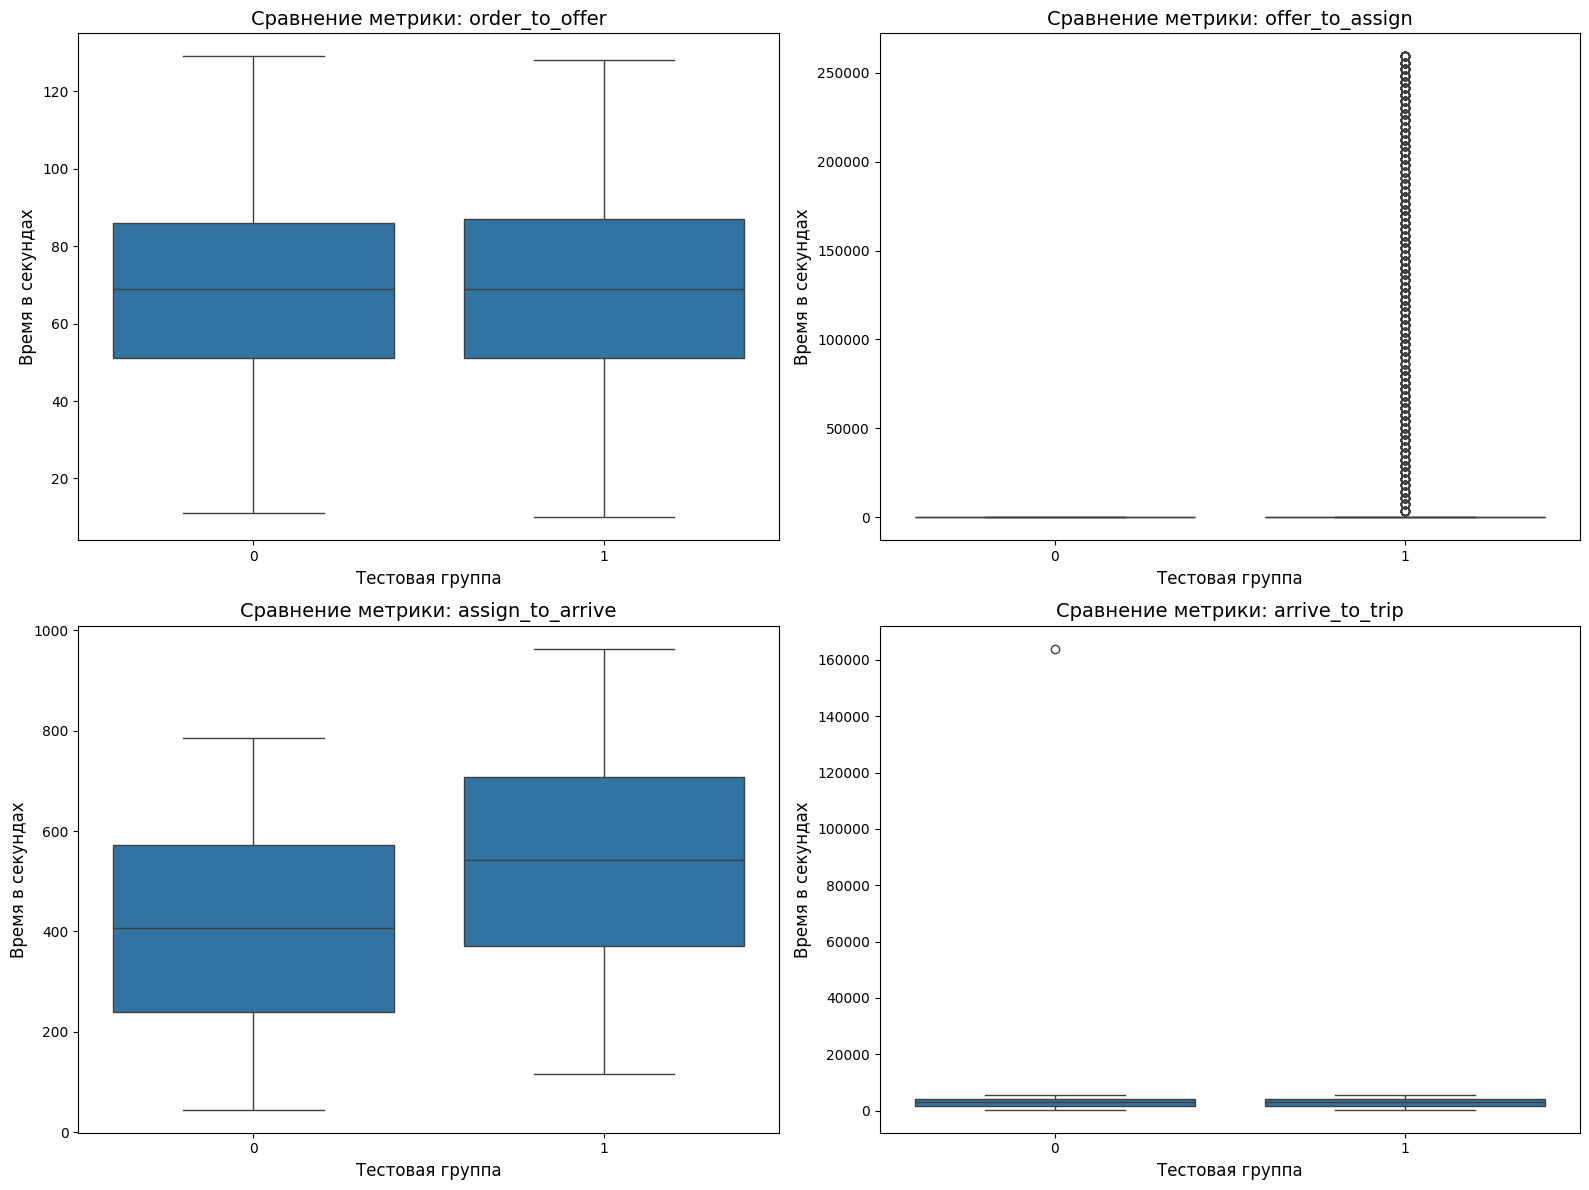

In [30]:
features = [
    'order_to_offer',
    'offer_to_assign',
    'assign_to_arrive',
    'arrive_to_trip'
]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))


for i, metric in enumerate(features):
    ax = axes.flatten()[i]

    sns.boxplot(ax=ax, data=df, x='test_group', y=metric)

    ax.set_title(f'Сравнение метрики: {metric}', fontsize=14)
    ax.set_xlabel('Тестовая группа', fontsize=12)
    ax.set_ylabel('Время в секундах', fontsize=12)


plt.tight_layout()


plt.show()

В столбце offer_to_assign нужно удалить все выбросы, тк клиент скорее всего забыл отменить заказ или это просто ошибка
Также выброс в arrive_to_trip нужно удалить, тк поездка 44 часа - явная ошибка в данных



In [102]:
df_to_clean = df.copy()

is_good_row = pd.Series([True] * len(df_to_clean), index=df_to_clean.index)

print(len(df_to_clean))

for col in features:
    if col in df_to_clean.columns:
        Q1 = df_to_clean.groupby('test_group')[col].transform(lambda x: x.quantile(0.25))
        Q3 = df_to_clean.groupby('test_group')[col].transform(lambda x: x.quantile(0.75))
        IQR = Q3 - Q1


        upper_bound = Q3 + 1.5 * IQR

        is_outlier_for_this_col = df_to_clean[col] > upper_bound

        is_good_row &= ~is_outlier_for_this_col

        print(f"В {col}: {is_outlier_for_this_col.sum()} выбросов")


df_clean = df_to_clean[is_good_row]


print(f"Выбросы: {len(df_to_clean) - len(df_clean)}")
print(len(df_clean))


12281
В order_to_offer: 0 выбросов
В offer_to_assign: 920 выбросов
В assign_to_arrive: 0 выбросов
В arrive_to_trip: 1 выбросов
Выбросы: 921
11360


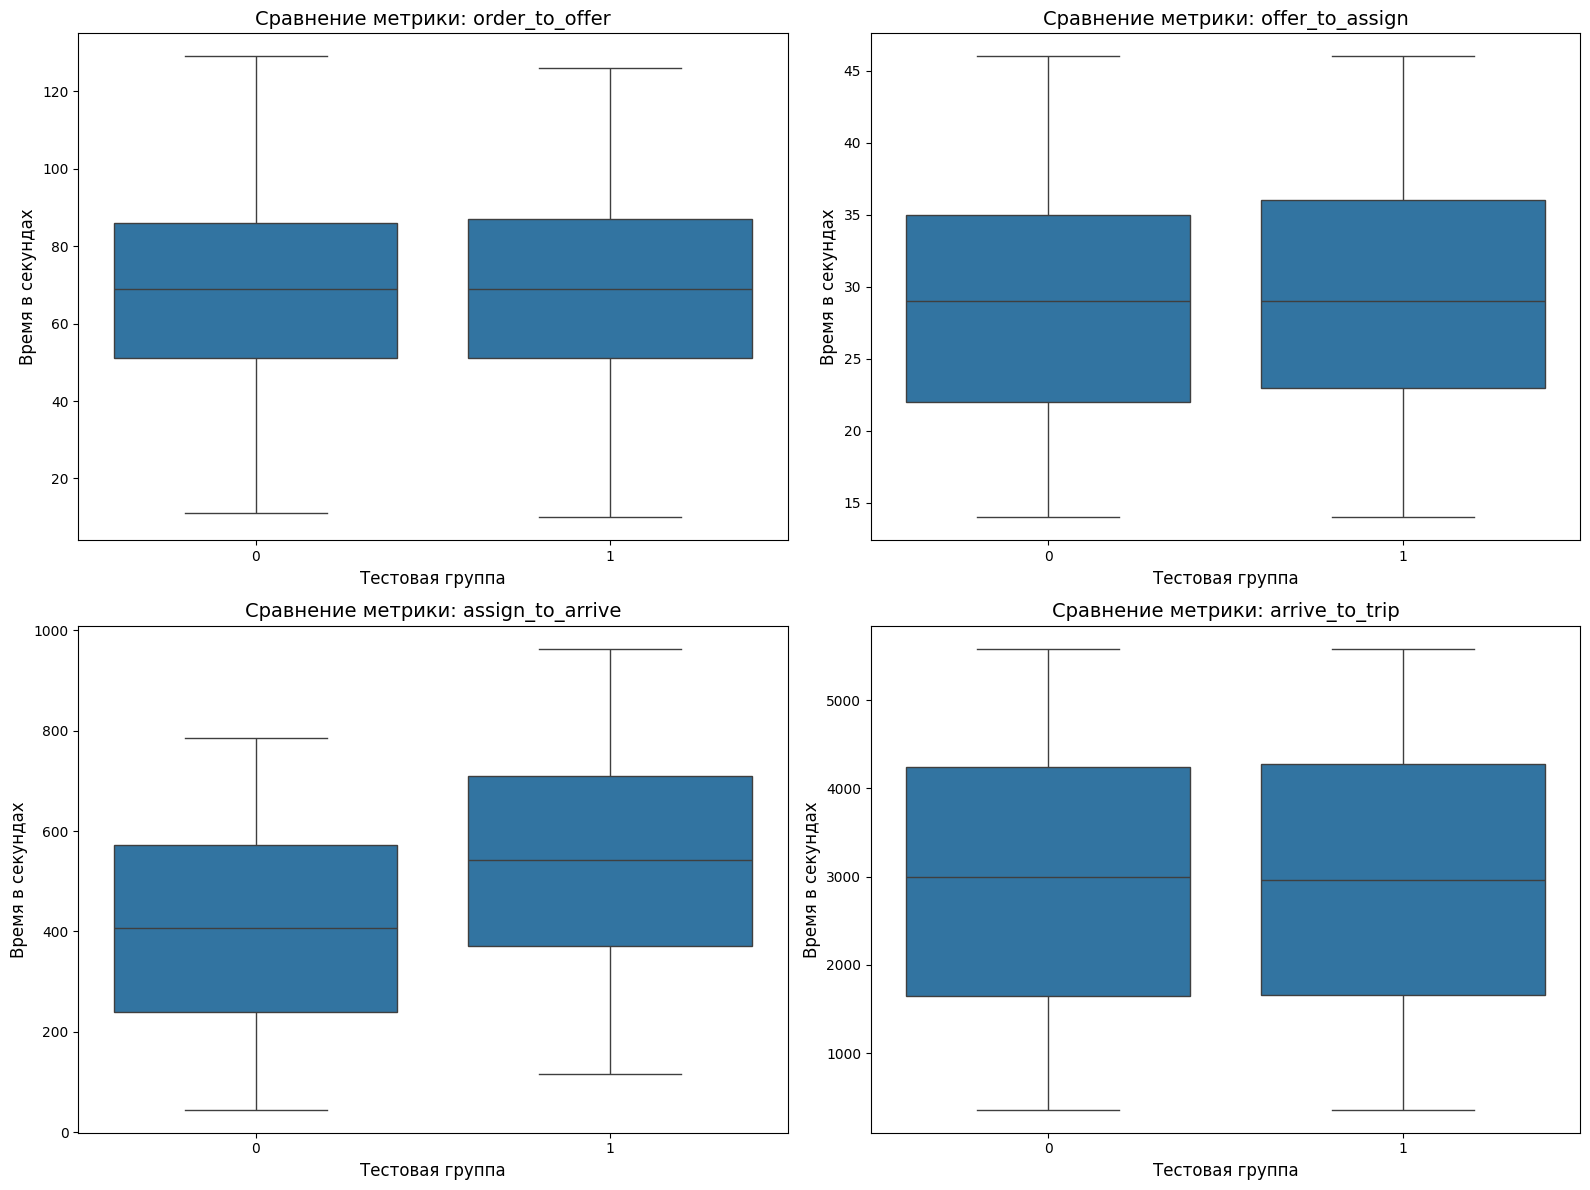

In [47]:
features = [
    'order_to_offer',
    'offer_to_assign',
    'assign_to_arrive',
    'arrive_to_trip'
]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))


for i, metric in enumerate(features):
    ax = axes.flatten()[i]

    sns.boxplot(ax=ax, data=df_clean, x='test_group', y=metric)

    ax.set_title(f'Сравнение метрики: {metric}', fontsize=14)
    ax.set_xlabel('Тестовая группа', fontsize=12)
    ax.set_ylabel('Время в секундах', fontsize=12)


plt.tight_layout()


plt.show()

В тестовой группе среднее время ожидания немного увеличилось, что в целом логично


# Подсчет ключевых метрик

Построим воронку, отображающую сумму целевых действий на каждом этапе

In [97]:
df_funnel = df_clean.groupby('test_group').agg({
    'time_order':'count',
    'time_offer': 'count',
    'time_assign': 'count',
    'time_arrive': 'count',
    'trip_time': 'count',
})
df_funnel.head()

,time_order,time_offer,time_assign,time_arrive,trip_time
test_group,,,,,
0,5683,4845,4284,3688,3561
1,5677,5015,4419,3392,3267


будем считать p-уровень значимости при помощи z-теста. t-тест здесь некорректен, так как мы считаем пропорции. Так как группы всего две, чи-квадрат тест не имеет смысла

In [60]:
from statsmodels.stats.proportion import proportions_ztest

Цель: понять, влияет ли увеличение радиуса на процент конверсии целевого действия клиента (assign)


Нулевая гипотеза: увеличение радиуса не повлияет на процент конверсии пользователей, совершивших целевое действие

Альтернативная гипотеза: увеличение радиуса ***положительно*** повлияет на процент конверсии пользователей, совершивших целевое действие

Отвергаем нулевую гипотезу, если p уровень значимости <0.05

In [71]:
z_stat_assign, p_value_assign = proportions_ztest(
    count=df_funnel.time_assign,
    nobs=df_funnel.time_order,
    alternative='two-sided'
)

z_stat_assign, p_value_assign

(np.float64(-3.0940973152930447), np.float64(0.0009870636069068091))

p уровень значимости явно меньше 0.05, следовательно отвергаем нулевую гипотезу о том, что увеличение радиуса не влияет на конверсию пользователей, совершивших целевое действие и принимаем альтернативную

---

Также в воронке видно, что уменьшилось число клиентов, дожидающихся такси (arrive) и клиентов заканчивающих свой заказ



Цель: понять, влияет ли увеличение радиуса на процент конверсии целевого действия клиента (arrive)

Нулевая гипотеза: увеличение радиуса не повлияет на процент конверсии пользователей, совершивших целевое действие

Альтернативная гипотеза: увеличение радиуса ***отрицательно*** повлияет на процент конверсии пользователей, совершивших целевое действие

Отвергаем нулевую гипотезу, если p уровень значимости <0.05

In [78]:
z_stat_trip, p_value_trip = proportions_ztest(
    count=df_funnel.time_arrive,
    nobs=df_funnel.time_order,
    alternative='two-sided'
)

z_stat_trip, p_value_trip

(np.float64(5.658755505580318), np.float64(1.524745881182443e-08))

p уровень значимости сильно меньше 0.05, следовательно отвергаем нулевую гипотезу и принимаем альтернативную о том, что увеличение радиуса негативно влияет на процент конверсии


---



Проделаем тоже самое, чтобы понять есть ли изменения на последнем этапе воронки

In [79]:
z_stat_trip, p_value_trip = proportions_ztest(
    count=df_funnel.trip_time,
    nobs=df_funnel.time_arrive,
    alternative='two-sided'
)

z_stat_trip, p_value_trip

(np.float64(0.5480033281583772), np.float64(0.5836896175860253))

p уровень здесь больше 0.05, следовательно принимаем нулевую гипотезу о том, что увеличение радиуса не влияет на конверсию завершивших поездку пользователей



---

Следовательно, увеличение радиуса влияет на то, что теперь пользователи чаще отменяют заказ

In [91]:
assign_to_arrive_0 = df_clean[df_clean.test_group == 0].assign_to_arrive.dropna()
assign_to_arrive_0

,assign_to_arrive
0,473.0
1,450.0
4,515.0
7,123.0
8,58.0
...,...
12261,361.0
12264,677.0
12265,723.0
12272,569.0


In [92]:
assign_to_arrive_1 = df_clean[df_clean.test_group == 1].assign_to_arrive.dropna()
assign_to_arrive_1

,assign_to_arrive
3,747.0
6,214.0
16,442.0
28,429.0
32,542.0
...,...
12267,394.0
12270,611.0
12274,604.0
12278,492.0


In [93]:
t_stat, p_value = ttest_ind(
    assign_to_arrive_1,
    assign_to_arrive_0,
    equal_var=False,
    alternative='two-sided'
)

In [94]:
t_stat, p_value

(np.float64(28.618818300966304), np.float64(2.0005172329607246e-170))

In [96]:
np.mean(assign_to_arrive_0) / 60, np.mean(assign_to_arrive_1) / 60

(np.float64(6.754365509761388), np.float64(9.008053262578617))

В тестовой группе пользователи ждут такси в среднем на 2 минуты 15 секунд дольше. Это статистически значимо

# Для презы

In [99]:
df_funnel = df_funnel.rename(columns={
    'time_order': 'Order',
    'time_offer': 'Offer',
    'time_assign': 'Assign',
    'time_arrive': 'Arrive',
    'trip_time': 'Trip'})

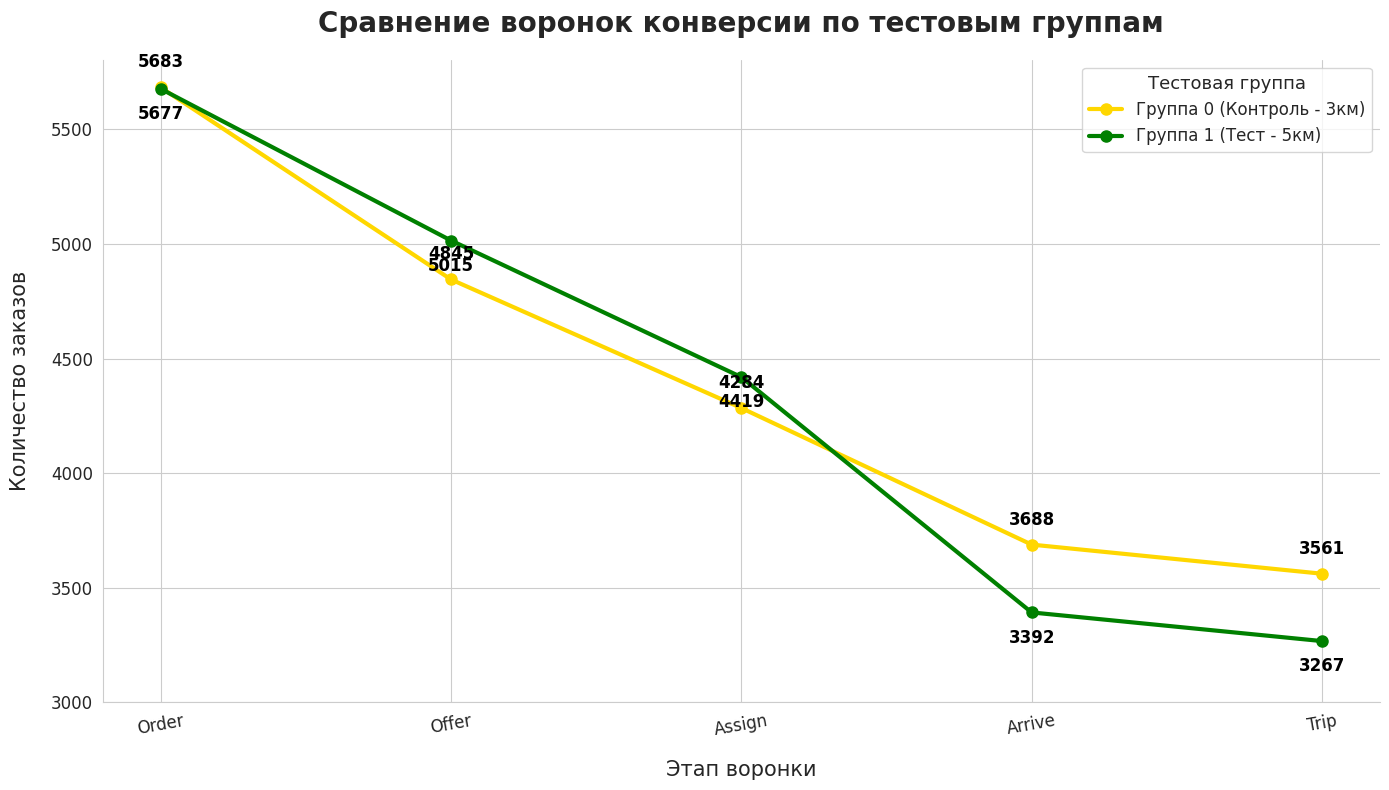

In [100]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))

stages = df_funnel.columns
group_0_counts = df_funnel.loc[0]
group_1_counts = df_funnel.loc[1]

plt.plot(stages, group_0_counts, marker='o', linestyle='-', color='gold', linewidth=3, markersize=8, label='Группа 0 (Контроль - 3км)')
plt.plot(stages, group_1_counts, marker='o', linestyle='-', color='green', linewidth=3, markersize=8, label='Группа 1 (Тест - 5км)')

for i, count in enumerate(group_0_counts):
    plt.text(i, count + 70, str(count), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

for i, count in enumerate(group_1_counts):
    plt.text(i, count - 150, str(count), ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.title('Сравнение воронок конверсии по тестовым группам', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Этап воронки', fontsize=15, labelpad=15)
plt.ylabel('Количество заказов', fontsize=15, labelpad=15)
plt.legend(title='Тестовая группа', fontsize=12, title_fontsize=13)

plt.xticks(fontsize=12, rotation=10)
plt.yticks(fontsize=12)
plt.ylim(bottom=3000)

sns.despine()
plt.tight_layout()

plt.show()